In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
%matplotlib inline

## LOAD RESOURCES ##

In [56]:
path = 'resources/food-inspections-cleaned.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,None,41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


In [57]:
nb_NaN_violations = len(df) - df['Violations'].count()
print("We have {} out of {} inspections with no violations recorded. It makes {}%.".format(nb_NaN_violations, len(df), "%.2f" % (nb_NaN_violations/len(df)*100)))

We have 51070 out of 191827 inspections with no violations recorded. It makes 26.62%.


## EXPLODE VIOLATIONS ##

In [58]:
df_split = df.copy()
df_split['Violations'] = df_split['Violations'].map(lambda x: str(x).split('|'))
df_split.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,[None],41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,Fail,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...",41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22


In [59]:
violations = df_split.explode('Violations').rename(columns={'Violations' : 'Violation'})
violations = violations[violations['Violation'] != 'None']
nb_violations = len(violations)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


## GET VIOLATIONS IDS ##

In [60]:
def get_violation_id(x):
    return x.split('.')[0].strip()

violations['Violation ID'] = violations['Violation'].apply(get_violation_id).astype(int)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53


In [61]:
violation_id_meaning = pd.read_csv('resources/violation-id-meaning.csv', delimiter=',').set_index('Violation ID')
violation_id_meaning.head()

,Meaning
Violation ID,
1,Suspicious source
2,No adequate food storage
3,Food storage temperature problems
4,Contamination
5,Disease among the staff


In [62]:
violations['Meaning'] = violations['Violation ID'].apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations[['Violation ID', 'Meaning']].head()

,Violation ID,Meaning
1,3,Food storage temperature problems
1,5,Disease among the staff
1,25,Poisonous and toxic materials used in dangerou...
1,50,None
1,53,None


## GET VIOLATIONS SEVERITY ##

In [63]:
def is_violation_high_severity(x):
    return x <= 14

def is_violation_medium_severity(x):
    return 15 <= x and x <= 29

def is_violation_low_severity(x):
    return 30 <= x

def get_violation_severity(x):
    if is_violation_high_severity(x):
        return 'High'
    if is_violation_medium_severity(x):
        return 'Medium'
    return 'Low'

violations['Violation Severity'] = violations['Violation ID'].apply(get_violation_severity)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID,Meaning,Violation Severity
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3,Food storage temperature problems,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5,Disease among the staff,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25,Poisonous and toxic materials used in dangerou...,Medium
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50,None,Low
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53,None,Low


## SAVE THE VIOLATIONS ORIENTED DATASET ##

In [64]:
violations.to_parquet('resources/violations_oriented.parquet')

## WHICH VIOLATIONS ARE THE MOST COMMON ? ##

In [65]:
all_violations_ids = violations['Violation ID'].unique()
all_violations_ids.sort()
all_violations_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70])

In [66]:
violations_id_count = violations[['Inspection ID', 'Violation ID']].groupby('Violation ID').count().rename(columns={'Inspection ID' : 'Count'})
violations_id_count['Meaning'] = violations_id_count.index.to_series().apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations_id_count.sort_values('Count', ascending=False).head(10)

,Count,Meaning
Violation ID,,
34,70545,Floors are not clean
35,63982,Walls or ceilings are not clean or not in good...
33,62443,Equipment or ustensils not cleaned after each use
38,57007,Flow of air from kitchen not discharged above ...
32,54139,Equipment or utensils not easily cleanable or ...
41,34645,Offensive odors / Cleaning equipment not store...
36,27642,Not enough light where food is prepared / No p...
3,18641,Food storage temperature problems
18,16844,No measures against infestations


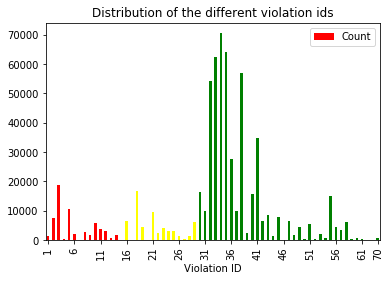

In [67]:
colors = [['red']*14 + ['yellow']*15 + ['green']*(len(violations_id_count) - 14 - 15)]
violations_id_count.plot.bar(color=colors)
plt.title("Distribution of the different violation ids")
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
xticks[-1].set_visible(True)

## ARE THE VIOLATIONS MOSTLY SEVERE ? ##

In [68]:
violations_severity_count = violations[['Inspection ID', 'Violation Severity']].groupby('Violation Severity').count().rename(columns={'Inspection ID' : 'Count'})
violations_severity_count['Percent'] = violations_severity_count['Count'].apply(lambda x: "%.3f" % (x/nb_violations*100))
violations_severity_count

,Count,Percent
Violation Severity,,
High,59917,9.657
Low,500952,80.740
Medium,59585,9.603


Text(0.5, 1.0, 'Distribution of the severity levels for the violations')

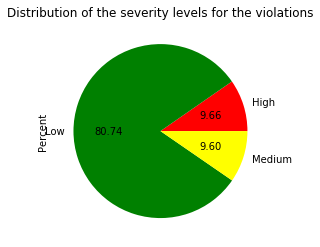

In [69]:
violations_severity_count['Percent'].astype(float).plot.pie(autopct='%.2f', colors=['red', 'green', 'yellow'], fontsize=10)
plt.title("Distribution of the severity levels for the violations")

In [70]:
df_violation_ids = df_split.copy()
df_violation_ids['Violation IDs'] = df_violation_ids['Violations'].apply(lambda violations: [get_violation_id(x) for x in violations])
df_violation_ids['Nb Violations'] = df_violation_ids['Violation IDs'].apply(lambda x: 0 if 'None' in x else len(x))
df_violation_ids[['Violations', 'Violation IDs', 'Nb Violations']].head()

,Violations,Violation IDs,Nb Violations
0,[None],[None],0
1,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 5, 25, 50, 53, 53, 56, 58]",8
2,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...","[38, 47, 53, 55, 58, 60]",6
3,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 48, 51, 55, 58]",5
4,[14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TA...,"[14, 25, 41, 47, 48, 55, 56, 57, 58, 60]",10


Text(0.5, 1.0, 'Distribution of the number of violations by inspection')

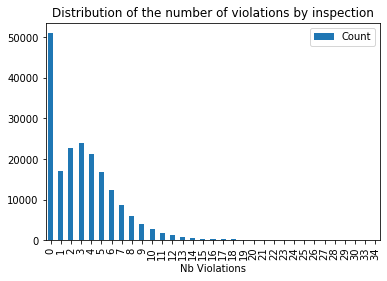

In [71]:
df_violation_ids[['Inspection ID', 'Nb Violations']].groupby('Nb Violations').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar()
plt.title("Distribution of the number of violations by inspection")

In [72]:
df_violation_ids['Nb Violations of high severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_high_severity(int(x))]))
df_violation_ids['Nb Violations of medium severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_medium_severity(int(x))]))
df_violation_ids['Nb Violations of low severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_low_severity(int(x))]))
df_violation_ids[['Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,0,0,0,0
1,8,2,1,5
2,6,0,0,6
3,5,1,0,4
4,10,1,1,8


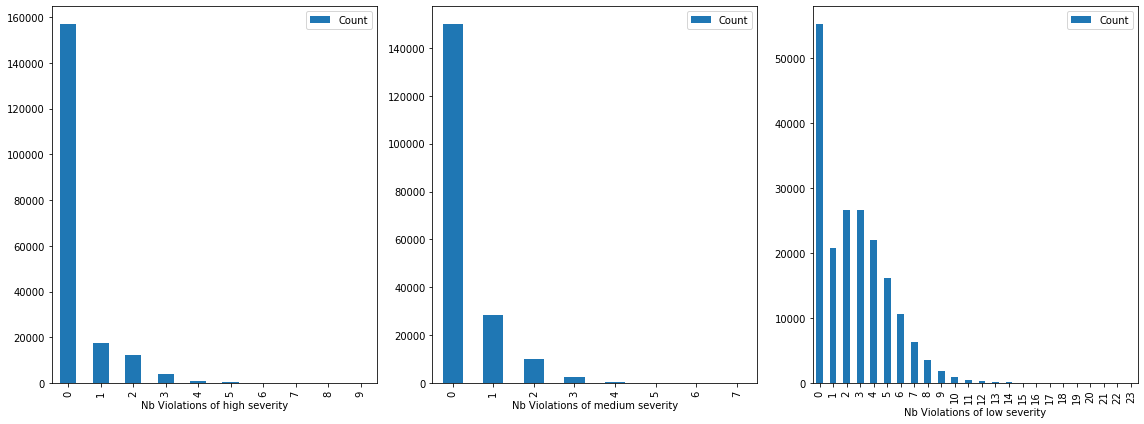

In [73]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df_violation_ids[['Inspection ID', 'Nb Violations of high severity']].groupby('Nb Violations of high severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax1)
df_violation_ids[['Inspection ID', 'Nb Violations of medium severity']].groupby('Nb Violations of medium severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax2)
df_violation_ids[['Inspection ID', 'Nb Violations of low severity']].groupby('Nb Violations of low severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax3)
plt.tight_layout()

## SAVE THE DATASET EXPANDED WITH MORE INFO ABOUT VIOLATIONS ##

In [74]:
df_violation_ids.to_parquet('resources/extended_dataset.parquet')

## HOW DOES THE NUMBER OF VIOLATIONS VARY OVER TIME ? ##

In [138]:
nb_violations_by_date = df_violation_ids[['Inspection Date', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Date').sum()
nb_violations_by_date.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Date,,,,
2010-01-04,16,0,3,13
2010-01-05,241,5,21,215
2010-01-06,266,13,38,215
2010-01-07,170,5,9,156
2010-01-08,121,4,8,109


In [139]:
nb_violations_by_date.sort_values('Nb Violations', ascending=False).head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Date,,,,
2019-05-20,591,148,61,382
2019-02-14,562,142,51,369
2019-04-25,555,113,62,380
2019-06-17,551,127,55,369
2019-02-21,525,143,70,312


Text(0.5, 1.0, 'Variation of the number of violations over time')

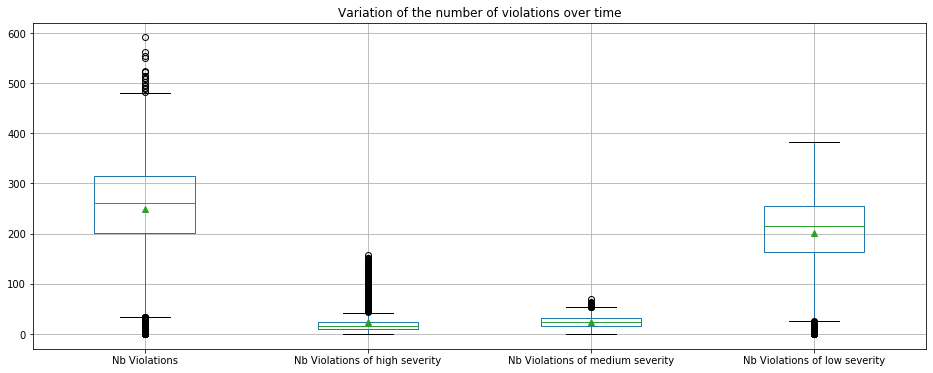

In [140]:
nb_violations_by_date.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the number of violations over days")

In [141]:
nb_violations_by_year = nb_violations_by_date.copy().reset_index()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').mean()
nb_violations_by_year.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Year,,,,
2010,203.207547,12.618868,17.377358,173.211321
2011,230.686047,12.802326,20.139535,197.744186
2012,220.359375,12.910156,20.515625,186.933594
2013,232.664000,12.504000,21.644000,198.516000
2014,262.138340,15.509881,23.055336,223.573123


Text(0.5, 1.0, 'Mean number of violations by day for each year')

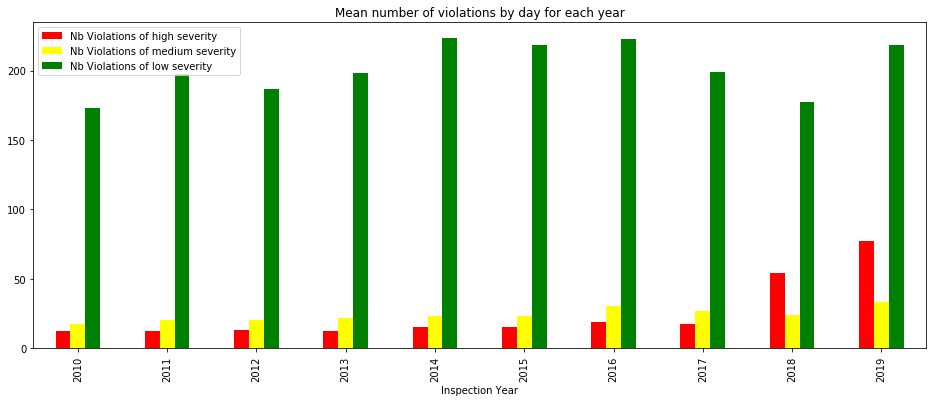

In [142]:
nb_violations_by_year[['Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].plot.bar(color=['red', 'yellow', 'green'], figsize=(16,6))
plt.title("Mean number of violations by day for each year")

## WHICH FACILITIY TYPES HAVE MORE VIOLATIONS ? ##

In [143]:
mean_nb_violations_by_facility = df_violation_ids[['Facility Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Facility Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_facility.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Facility Type,,,,
Long term care center,3.838488,0.441237,0.319588,3.077663
Bakery,3.661017,0.318921,0.308890,3.033207
Restaurant,3.454538,0.339556,0.332285,2.782697
Grocery store,3.374856,0.300829,0.339350,2.734677
Gas station,3.204545,0.350000,0.318182,2.536364


In [144]:
mean_nb_violations_by_facility.sort_values('Nb Violations').head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Facility Type,,,,
Unknown,0.091025,0.014183,0.009102,0.067739
Shared kitchen,0.889590,0.078864,0.075710,0.735016
Mobile food dispenser,1.213759,0.366708,0.193489,0.653563
Rooftop,1.718310,0.295775,0.126761,1.295775
Coffee shop,1.741641,0.224924,0.170213,1.346505


Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

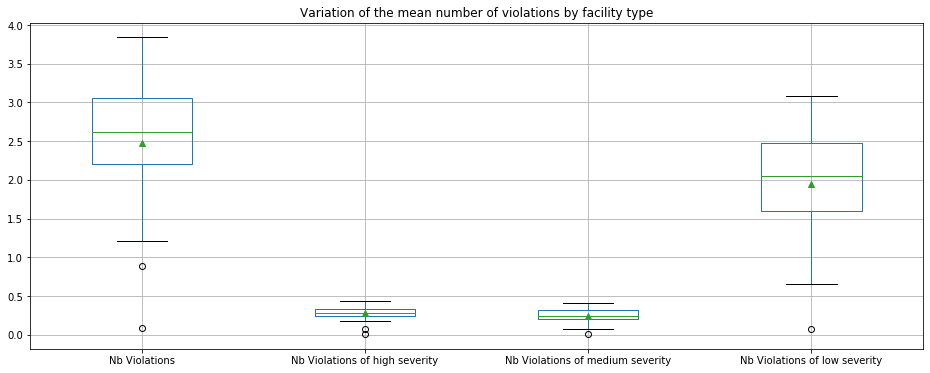

In [145]:
mean_nb_violations_by_facility.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

## WHICH COMMUNITES HAVE MORE VIOLATIONS ? ##

In [146]:
mean_nb_violations_by_community = df_violation_ids[['Community', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Community').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_community.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Community,,,,
SOUTH LAWNDALE,4.070784,0.392162,0.378622,3.300000
WEST RIDGE,3.977311,0.376145,0.367402,3.233764
MORGAN PARK,3.940287,0.376417,0.354497,3.209373
HYDE PARK,3.910539,0.399532,0.349415,3.161593
WASHINGTON PARK,3.902475,0.352256,0.462882,3.087336


In [147]:
mean_nb_violations_by_community.sort_values('Nb Violations').head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Community,,,,
RIVERDALE,2.551913,0.158470,0.295082,2.098361
NEAR SOUTH SIDE,2.620533,0.315551,0.248113,2.056870
LOOP,2.643874,0.271700,0.223953,2.148221
GARFIELD RIDGE,2.716601,0.209234,0.215128,2.292240
EAST SIDE,2.746398,0.255043,0.234870,2.256484


Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

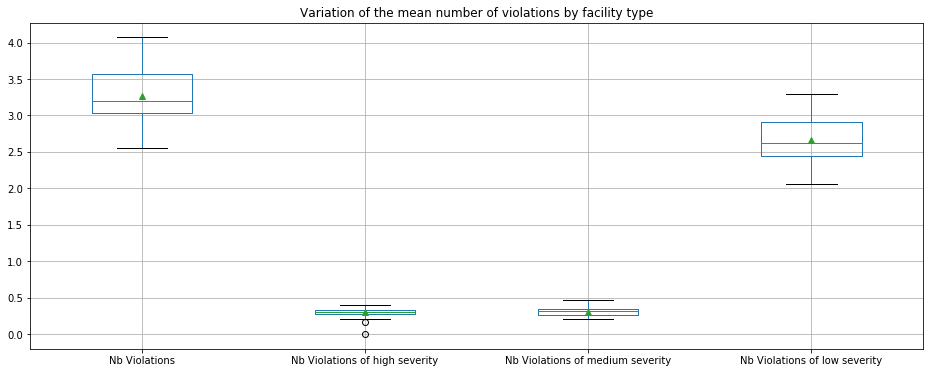

In [148]:
mean_nb_violations_by_community.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

## HOW MUCH FAILING AN INSPECTION IS LINKED TO THE NUMBER OF VIOLATIONS ? ##

In [149]:
mean_nb_violations_by_result = df_violation_ids[['Results', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Results').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Results,,,,
Fail,5.828375,0.720298,1.158481,3.949596
Pass w/ Conditions,5.374891,1.232511,0.593343,3.549037
Pass,2.503328,0.004154,0.003613,2.495561
No Entry,0.355581,0.021221,0.058318,0.276041
Not Ready,0.163377,0.036184,0.019189,0.108004


In [150]:
mean_nb_violations_by_result_and_reinspection = df_violation_ids[['Results', 'Re-inspection', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby(['Results', 'Re-inspection']).mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result_and_reinspection

Nb Violations  \
Results              Re-inspection                  
Fail                 False               5.876186   
Not Ready            True                5.428571   
Pass w/ Conditions   False               5.407404   
Fail                 True                5.306931   
Pass w/ Conditions   True                5.195188   
No Entry             True                4.383041   
Pass                 False               2.809281   
                     True                1.719682   
Out of Business      True                0.604167   
No Entry             False               0.119362   
Not Ready            False               0.060369   
Out of Business      False               0.002355   
Business Not Located False               0.000000   

                                    Nb Violations of high severity  \
Results              Re-inspection                                   
Fail                 False                                0.712516   
Not Ready            True                                 1.371429   
Pass w/ Conditions   False                                1.241328   
Fail                 True                                 0.805174   
Pass w/ Conditions   True                                 1.183780   
No Entry             True                                 0.330409   
Pass                 False                                0.003976   
                     True                                 0.004610   
Out of Business      True                                 0.010417   
No Entry             False                                0.003087   
Not Ready            False                                0.010061   
Out of Business      False                                0.000060   
Business Not Located False                                0.000000   

                                    Nb Violations of medium severity  \
Results              Re-inspection                                     
Fail                 False                                  1.196146   
Not Ready            True                                   0.657143   
Pass w/ Conditions   False                                  0.594660   
Fail                 True                                   0.747684   
Pass w/ Conditions   True                                   0.586062   
No Entry             True                                   1.023392   
Pass                 False                                  0.002888   
                     True                                   0.005470   
Out of Business      True                                   0.125000   
No Entry             False                                  0.001715   
Not Ready            False                                  0.006708   
Out of Business      False                                  0.000121   
Business Not Located False                                  0.000000   

                                    Nb Violations of low severity  
Results              Re-inspection                                 
Fail                 False                               3.967524  
Not Ready            True                                3.400000  
Pass w/ Conditions   False                               3.571416  
Fail                 True                                3.754072  
Pass w/ Conditions   True                                3.425347  
No Entry             True                                3.029240  
Pass                 False                               2.802418  
                     True                                1.709602  
Out of Business      True                                0.468750  
No Entry             False                               0.114560  
Not Ready            False                               0.043600  
Out of Business      False                               0.002174  
Business Not Located False                               0.000000

## WHICH INSPECTION TYPES GIVE MORE VIOLATIONS ? ##

In [151]:
mean_nb_violations_by_inspection_type = df_violation_ids[['Inspection Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_inspection_type

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Type,,,,
Suspect food poisoning,4.615992,0.614018,0.436328,3.565647
Complaint,4.095401,0.411173,0.416451,3.267778
Canvass,3.294673,0.289900,0.298332,2.706441
Others,3.138219,0.163265,0.171614,2.803340
Consultation,2.434655,0.099853,0.221733,2.113069
Task-force,2.352877,0.301846,0.398480,1.652552
License,2.240957,0.301583,0.256959,1.682416
Cancelled,0.125749,0.000000,0.017964,0.107784
Unknown,0.000000,0.000000,0.000000,0.000000


## DO THE RISKY ENVIRONNEMENTS HAVE LESS/MORE VIOLATIONS ? ##

In [152]:
mean_nb_violations_by_risk = df_violation_ids[['Risk', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Risk').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_risk

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Risk,,,,
High,3.501277,0.342406,0.323039,2.835832
Medium,2.908922,0.267915,0.310835,2.330173
Low,1.775420,0.164988,0.209293,1.401139
All,0.000000,0.000000,0.000000,0.000000


## CAN WE SEE PERIODS OF INFESTATIONS ? ##

In [163]:
infestation_id = '13'
df_violations_infestation = df_violation_ids[df_violation_ids.apply(lambda x: infestation_id in x['Violation IDs'], axis=1)]
df_violations_infestation.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
202,2316048,DUNKIN DONUTS/BASKIN ROBBINS,DUNKIN DONUTS/BASKIN ROBBINS,1909364,Restaurant,Medium,6925 S PULASKI RD,60629,2019-10-17,Complaint,...,False,WEST LAWN,WEST LAWN,13,41,"[1, 2, 10, 13, 16, 38, 47, 47, 49, 55, 55, 57,...",13,4,1,8
799,2313152,FRUITERIA FAVELA,FRUITERIA FAVELA,2551070,Grocery store,Medium,2959 W 59TH ST,60629,2019-10-01,Canvass,...,False,CHICAGO LAWN,"MARQUETTE PARK,GAGE PARK",16,32,"[3, 5, 10, 13, 23, 35, 36, 38, 47, 48, 49, 53,...",15,4,1,10
2370,2311293,RICO FRESH MARKET,RICO FRESH MARKET,2245840,Grocery store,High,3552 W ARMITAGE AVE,60647,2019-08-26,Complaint,...,False,LOGAN SQUARE,LOGAN SQUARE,26,37,"[10, 13, 36, 37, 38, 49, 54, 55, 55, 55, 56, 56]",12,2,0,10


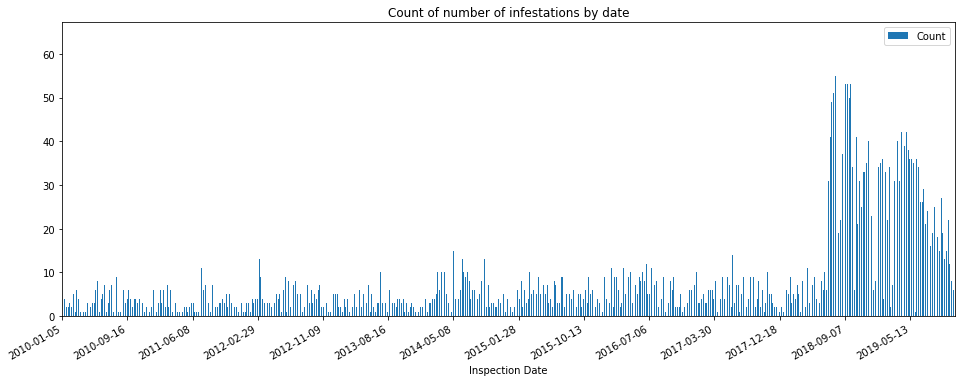

In [158]:
nb_infestations_by_date = df_violations_infestation[['Inspection Date', 'Inspection ID']].groupby('Inspection Date').count().rename(columns={'Inspection ID': 'Count'})
nb_infestations_by_date.plot.bar(figsize=(16,6))

plt.title("Count of number of infestations by day")
ax = plt.gca()
plt.gcf().autofmt_xdate()
ax.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in nb_infestations_by_date.index])
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if (i % (24*7) != 0): # 1 week
        tick.set_visible(False)

Text(0.5, 1.0, 'Mean number of infestations by date for each year')

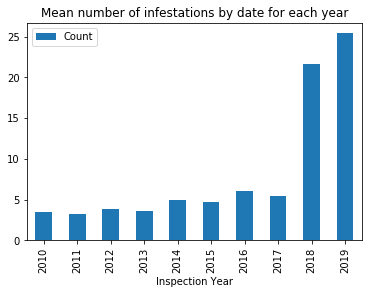

In [171]:
nb_infestations_by_year = nb_infestations_by_date.copy().reset_index()
nb_infestations_by_year['Inspection Date'] = nb_infestations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_infestations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_infestations_by_year = nb_infestations_by_year.groupby('Inspection Year').mean()
nb_infestations_by_year.plot.bar()
plt.title("Mean number of infestations by day for each year")

We clearly see an invasion since 2018 ! https://southsideweekly.com/i-smell-a-rat/

Text(0.5, 1.0, 'Mean number of infestations by day for each month')

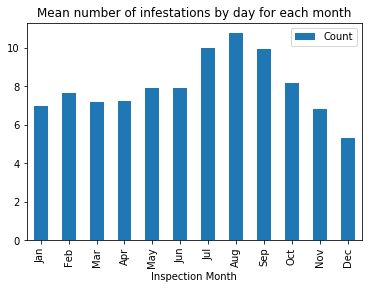

In [185]:
nb_infestations_by_month = nb_infestations_by_date.copy().reset_index()
nb_infestations_by_month['Inspection Date'] = nb_infestations_by_month['Inspection Date'].apply(lambda x: x.month)
nb_infestations_by_month.rename(columns={'Inspection Date' : 'Inspection Month'}, inplace=True)
nb_infestations_by_month = nb_infestations_by_month.groupby('Inspection Month').mean()
nb_infestations_by_month.plot.bar()
plt.gca().set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Mean number of infestations by day for each month")

We have more infestations in summer, not a big surprise.

## CAN WE FIND SOME POSSIBLE CAUSES TO THE RODENT INVATION ? ##

#### Can we see an augmentation of the "no measure against infestation" violations just before the plague ? ####

In [178]:
potential_infestation_id = '18'
df_violations_potential_infestation = df_violation_ids[df_violation_ids.apply(lambda x: potential_infestation_id in x['Violation IDs'] and infestation_id not in x['Violation IDs'], axis=1)]
df_violations_potential_infestation.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
179,2316093,CERMAK PRODUCE,CERMAK PRODUCE,2693885,Grocery store,High,4804-4810 W DIVERSEY AVE,60639,2019-10-18,License,...,False,BELMONT CRAGIN,"BELMONT CRAGIN,HERMOSA",31,27,"[1, 3, 5, 10, 18, 33, 36, 38, 43, 55, 55, 56]",12,4,1,7
12831,2261346,MASTERS PANCAKE HOUSE,MASTERS PANCAKE HOUSE,2767,Restaurant,High,5265 S CICERO AVE,60632,2019-02-01,Canvass,...,False,GARFIELD RIDGE,MIDWAY AIRPORT,14,18,"[3, 5, 18, 23, 25, 58]",6,2,3,1
15686,2240491,SUSUPUATO RESTAURANT & TAQUERIA,SUSUPUATO RESTAURANT & TAQUERIA,2511023,Restaurant,High,6161 N BROADWAY,60660,2018-11-20,Canvass,...,False,EDGEWATER,EDGEWATER,48,32,"[3, 5, 18, 23, 48, 58]",6,2,2,2


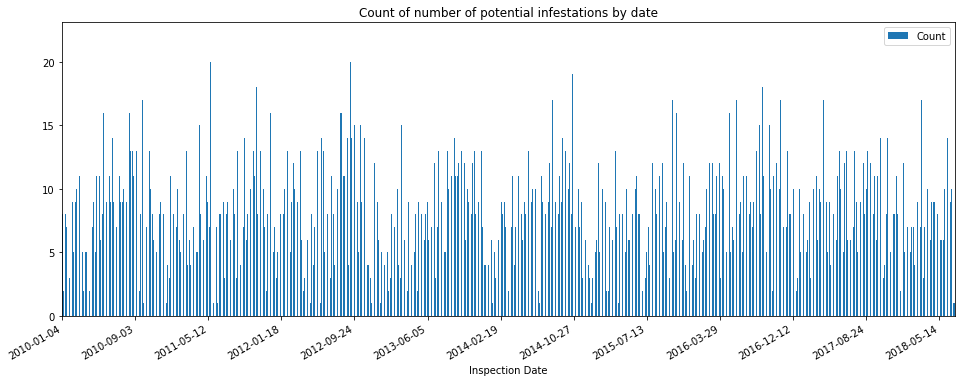

In [179]:
nb_potential_infestations_by_date = df_violations_potential_infestation[['Inspection Date', 'Inspection ID']].groupby('Inspection Date').count().rename(columns={'Inspection ID': 'Count'})
nb_potential_infestations_by_date.plot.bar(figsize=(16,6))

plt.title("Count of number of potential infestations by date")
ax = plt.gca()
plt.gcf().autofmt_xdate()
ax.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in nb_potential_infestations_by_date.index])
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if (i % (24*7) != 0): # 1 week
        tick.set_visible(False)

Text(0.5, 1.0, 'Mean number of potential infestations by date for each year')

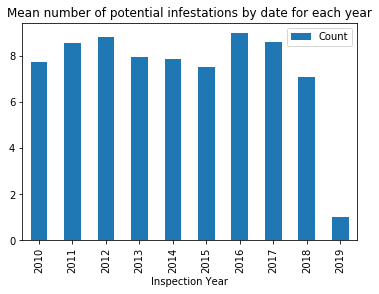

In [180]:
nb_potential_infestations_by_year = nb_potential_infestations_by_date.copy().reset_index()
nb_potential_infestations_by_year['Inspection Date'] = nb_potential_infestations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_potential_infestations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_potential_infestations_by_year = nb_potential_infestations_by_year.groupby('Inspection Year').mean()
nb_potential_infestations_by_year.plot.bar()
plt.title("Mean number of potential infestations by date for each year")

We see a very slight augmentation of "lack of protection against infestations" violations in 2016-2017 but not enough to conclude anything.

####  ####